# Notebook for visualizing the results of a stylegan3 training


In [1]:
import os, json
import matplotlib.pyplot as plt

results_dir = "training-runs/MNIST"
experiment_name = "00003-stylegan3-t-mnist-gpus2-batch64-gamma0.125"
file_name = "stats.jsonl"

file_path = os.path.join(results_dir, experiment_name, file_name)
if not os.path.isfile(file_path):
    print(f"Error: The file {file_path} does not exist.")

In [2]:
import numpy as np


def read_jsonl(file_path):
    """
    Reads a JSONL file and returns a list of parsed JSON objects.
    """
    with open(file_path, "r") as f:
        return [json.loads(line) for line in f]


def extract_metrics(jsonl_data, num_classes=10):
    """
    Extracts metrics from the JSONL data into a dictionary of lists.
    """
    metric_keys = [
        "Loss/scores/fake",
        "Loss/signs/fake",
        "Loss/G/loss",
        "Loss/scores/real",
        "Loss/signs/real",
        "Loss/D/loss",
        "Loss/r1_penalty",
        "Loss/D/reg",
        "Progress/tick",
        "Progress/kimg",
        "Timing/total_sec",
        "Timing/sec_per_tick",
        "Timing/sec_per_kimg",
        "Timing/maintenance_sec",
        "Resources/cpu_mem_gb",
        "Resources/peak_gpu_mem_gb",
        "Resources/peak_gpu_mem_reserved_gb",
        "Progress/augment",
        "Timing/total_hours",
        "Timing/total_days",
        "Timing/Gboth",
        "Timing/Dmain",
        "Timing/Dreg",
        "timestamp",
    ]
    metric_keys.extend([f"Loss/classification/{c}" for c in range(num_classes)])
    metrics = {key: [] for key in metric_keys}

    for entry in jsonl_data:
        for key in metric_keys:
            if key in entry:
                # Handle nested keys with "mean" values
                if isinstance(entry[key], dict) and "mean" in entry[key]:
                    metrics[key].append(entry[key]["mean"])
                else:
                    metrics[key].append(entry[key])
            else:
                metrics[key].append(None)  # Handle missing keys gracefully

    return metrics


def plot_metric(data, metrics=["Loss/D/loss"], x_axis="Progress/kimg", marker="o"):
    """
    Plots a specific metric against the x-axis (default is Progress/kimg).
    """
    for metric in metrics:
        if metric not in data:
            print(f"Warning: Metric {metric} not found in data.")
            return

    if x_axis not in data:
        print(f"Warning: X-axis {x_axis} not found in data.")
        return

    plt.figure(figsize=(10, 5))
    for metric in metrics:
        plt.plot(data[x_axis], data[metric], label=metric, marker=marker)
    plt.xlabel(x_axis)
    plt.ylabel("Metrics Value")
    plt.title("".join(metrics) + " vs " + x_axis)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


def print_accuracies_per_class(data, last_ticks=10):
    """
    Prints the accuracies for each class from the classification loss metrics.
    """
    classification_keys = [f"Loss/classification/{c}" for c in range(10)]
    accuracies = [data[metric][-last_ticks:] for metric in classification_keys]
    accuracies = np.array(accuracies)
    print(f"Last {last_ticks} accuracies per class:")
    for i, acc in enumerate(accuracies):
        print(f"Class {i}: {acc}")
    print(f"Average accuracies over the last {last_ticks} ticks: {np.mean(accuracies, axis=0)}")


def compute_avg_accuracy(data):
    """
    Computes the average accuracy from the classification loss metrics.
    """
    classification_keys = [f"Loss/classification/{c}" for c in range(10)]
    accuracies = [data[metric] for metric in classification_keys]
    accuracies = np.array(accuracies)
    return np.mean(accuracies, axis=0), np.std(accuracies, axis=0)


def plot_avg_accuracy(data):
    """
    Plots the average accuracy over time.
    """
    avg_accuracy, std_accuracy = compute_avg_accuracy(data)
    plt.figure(figsize=(10, 5))
    plt.plot(data["Progress/kimg"], avg_accuracy, label="Average Accuracy", marker="o")
    plt.fill_between(
        data["Progress/kimg"],
        avg_accuracy - std_accuracy,
        avg_accuracy + std_accuracy,
        alpha=0.2,
        label="Standard Deviation",
    )
    plt.xlabel("Progress/kimg")
    plt.ylabel("Average Accuracy")
    plt.title("Average Accuracy vs Progress/kimg")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

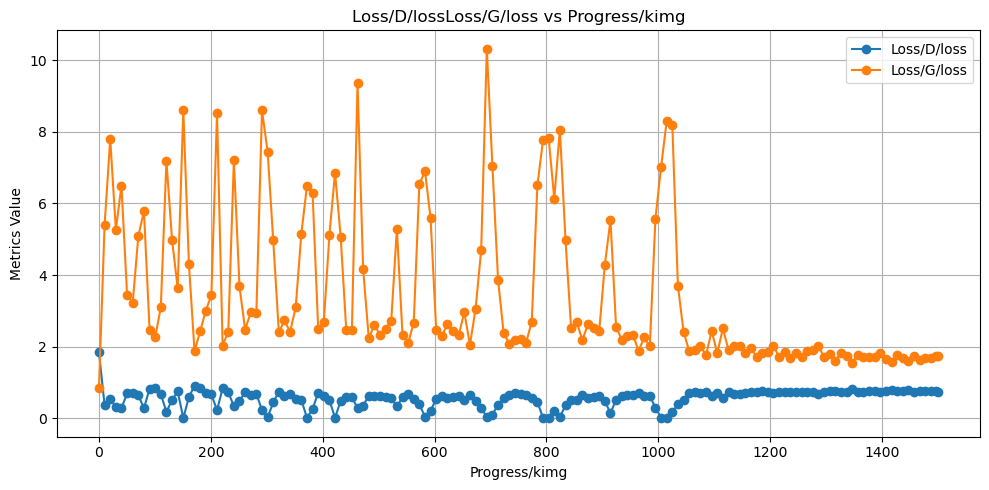

In [ ]:
jsonl_data = read_jsonl(file_path)
metrics = extract_metrics(jsonl_data)
plot_metric(metrics, metrics=["Loss/D/loss", "Loss/G/loss"], x_axis="Progress/kimg")

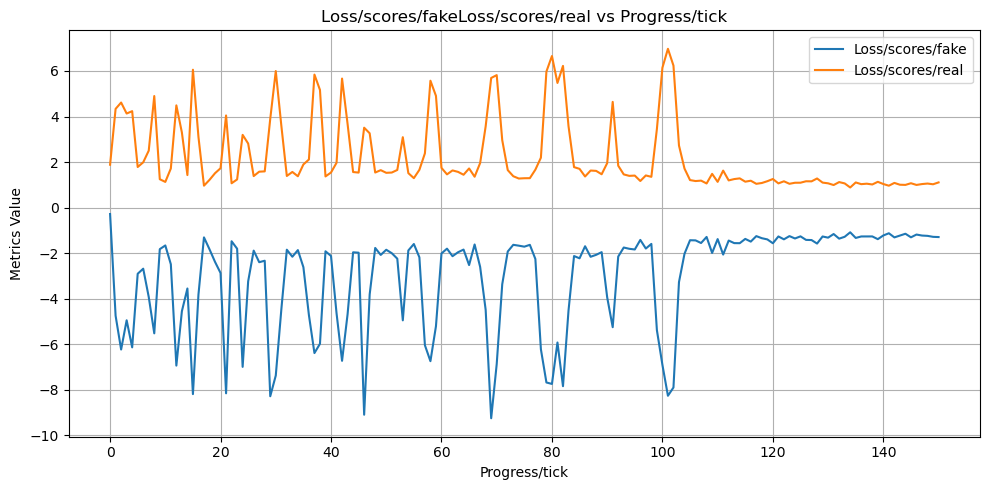

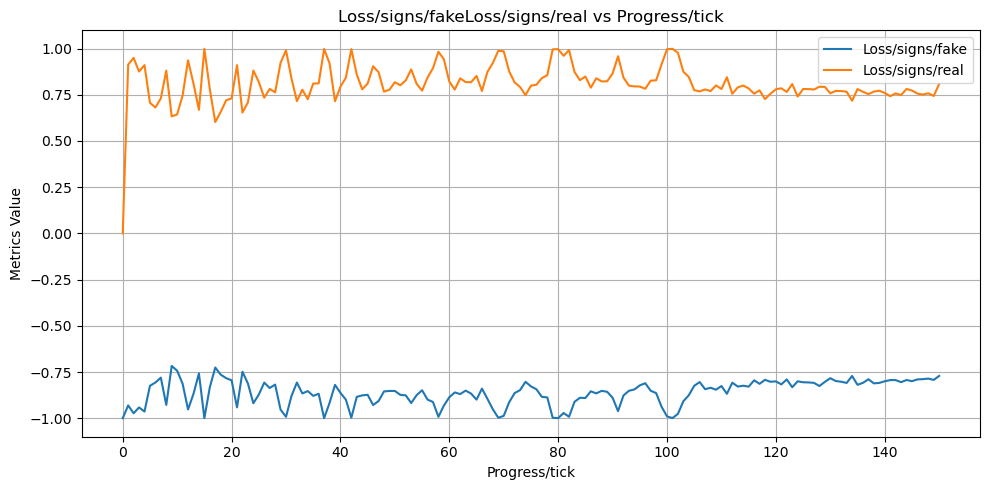

In [4]:
plot_metric(metrics, metrics=["Loss/scores/fake", "Loss/scores/real"], x_axis="Progress/tick", marker=None)
plot_metric(metrics, metrics=["Loss/signs/fake", "Loss/signs/real"], x_axis="Progress/tick", marker=None)

Last 10 accuracies per class:
Class 0: [0.38314176 0.276      0.49578257 0.46298032 0.50852273 0.58445298
 0.48773307 0.61987238 0.44066148 0.33121019]
Class 1: [0.8524173  0.86750789 0.87541806 0.8226087  0.86038394 0.86721311
 0.83505155 0.82571182 0.85944115 0.82315113]
Class 2: [0.66935484 0.65533981 0.67702448 0.74643875 0.72718808 0.59981256
 0.68181818 0.6710775  0.55188246 0.54166667]
Class 3: [0.59232828 0.46548507 0.40070299 0.43918292 0.62779851 0.53473492
 0.427695   0.48876404 0.5499515  0.66139241]
Class 4: [0.66829268 0.70210632 0.6615245  0.71000935 0.68036072 0.65464896
 0.67085202 0.6805293  0.6152381  0.59927798]
Class 5: [0.68848997 0.68214654 0.63991552 0.72691162 0.67305644 0.68387097
 0.71625616 0.68865979 0.67427386 0.64214047]
Class 6: [0.68596663 0.72177055 0.61343013 0.62059104 0.74760994 0.60523666
 0.64666667 0.55963303 0.71547729 0.64575646]
Class 7: [0.68553459 0.74262735 0.67389255 0.77384196 0.75515464 0.75497288
 0.68785579 0.77817214 0.73674912 0.7812

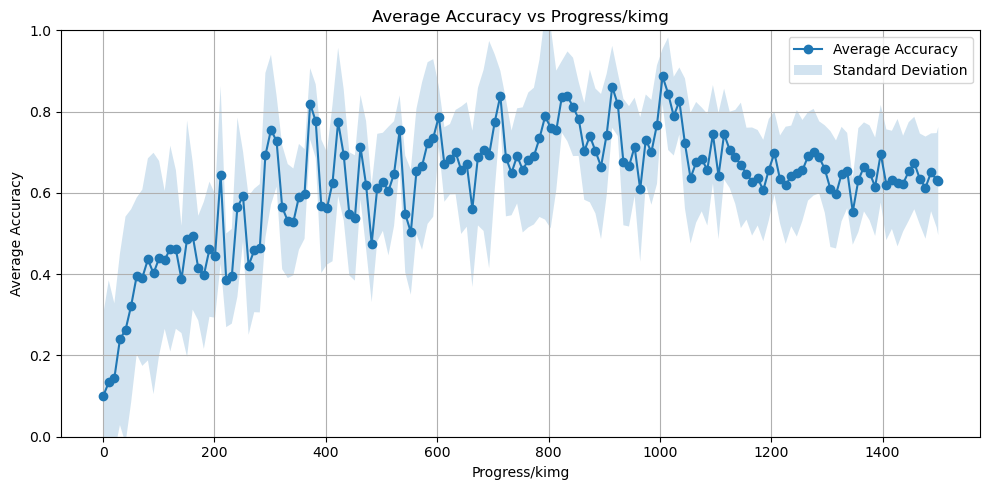

In [5]:
print_accuracies_per_class(metrics)
plot_avg_accuracy(metrics)

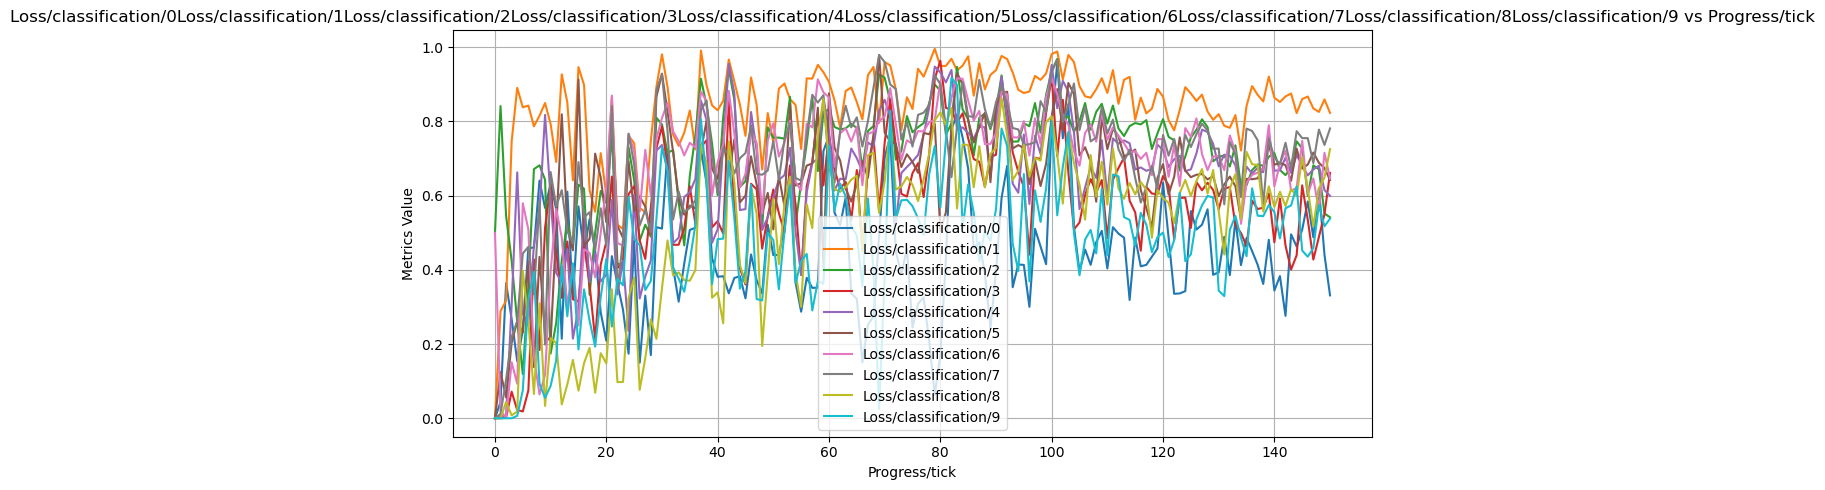

In [6]:
plot_metric(metrics, metrics=[f"Loss/classification/{c}" for c in range(10)], x_axis="Progress/tick", marker=None)